## lets try transfer learning

In [6]:
import os
import shutil
import cv2

In [7]:
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [8]:
!kaggle datasets download -d amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset

 99% 1.90G/1.91G [00:49<00:00, 29.5MB/s]
100% 1.91G/1.91G [00:49<00:00, 41.2MB/s]


In [9]:
from zipfile import ZipFile
fname='covid19-pneumonia-normal-chest-xray-pa-dataset.zip'
with ZipFile(fname,'r') as zip:
  zip.extractall()
  print('done')

done


In [10]:
os.mkdir('covid2')
os.mkdir('normal2')
os.mkdir('pneumonia2')

In [11]:
files=os.listdir('normal')
for f in files:
  image = cv2.imread(os.path.join('normal',f))
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(os.path.join('normal2',f),gray)

files1=os.listdir('covid')
for f in files1:
  image = cv2.imread(os.path.join('covid',f))
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(os.path.join('covid2',f'{f}.png'),gray)

files2=os.listdir('pneumonia')
for f in files2:
  image = cv2.imread(os.path.join('pneumonia',f))
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  cv2.imwrite(os.path.join('pneumonia2',f),gray)

In [12]:
os.mkdir('Dataset')
shutil.move('covid2','Dataset')
shutil.move('normal2','Dataset')
shutil.move('pneumonia2','Dataset')

'Dataset/pneumonia2'

In [13]:
os.chdir('Dataset')
os.rename('covid2','0')
os.rename('normal2','1')
os.rename('pneumonia2','2')

os.chdir('../')

In [14]:
import random
os.chdir('Dataset')
if os.path.isdir('train/0/') is False:
  os.mkdir('train')
  os.mkdir('test')
  os.mkdir('valid')

  for i in range(0,3):
    shutil.move(f'{i}','train')
    os.mkdir(f'test/{i}')
    os.mkdir(f'valid/{i}')


    test_samples=random.sample(os.listdir(f'train/{i}'),100)
    for j in test_samples:
      shutil.move(f'train/{i}/{j}',f'test/{i}')

    valid_samples=random.sample(os.listdir(f'train/{i}'),200)
    for j in valid_samples:
      shutil.move(f'train/{i}/{j}',f'valid/{i}') 

os.chdir("../")  

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image

In [29]:
train_datagen=image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=.1,
    shear_range=.1,
    horizontal_flip=True
                                       )

test_datagen=image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
                                       )
valid_datagen=image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
                                       )

In [30]:
train_path='Dataset/train'
test_path='Dataset/test'
valid_path='Dataset/valid'

In [31]:
train_gen=train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    color_mode='rgb'
)

test_gen=test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    color_mode='rgb'
)

valid_gen=valid_datagen.flow_from_directory(
    valid_path,
    target_size=(224,224),
    batch_size=32,
    color_mode='rgb'
)

Found 6039 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [32]:
vgg16_model=tf.keras.applications.vgg16.VGG16()

In [33]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [46]:
 model=Sequential()
 for layer in vgg16_model.layers[:-6]:
   model.add(layer)

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [48]:
for layer in model.layers:
  layer.trainable=False

In [49]:
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [39]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [40]:
model.fit(train_gen,validation_data=valid_gen,epochs=20,batch_size=128,shuffle=True,verbose=2)

Epoch 1/20
189/189 - 157s - loss: 1.1612 - accuracy: 0.6771 - val_loss: 0.4952 - val_accuracy: 0.8600
Epoch 2/20
189/189 - 156s - loss: 0.5888 - accuracy: 0.7874 - val_loss: 0.4046 - val_accuracy: 0.8767
Epoch 3/20
189/189 - 156s - loss: 0.4997 - accuracy: 0.8236 - val_loss: 0.3581 - val_accuracy: 0.8967
Epoch 4/20
189/189 - 155s - loss: 0.4543 - accuracy: 0.8422 - val_loss: 0.3109 - val_accuracy: 0.9017
Epoch 5/20
189/189 - 154s - loss: 0.4147 - accuracy: 0.8568 - val_loss: 0.3298 - val_accuracy: 0.8850
Epoch 6/20
189/189 - 155s - loss: 0.3736 - accuracy: 0.8746 - val_loss: 0.2768 - val_accuracy: 0.9133
Epoch 7/20
189/189 - 154s - loss: 0.3560 - accuracy: 0.8813 - val_loss: 0.2595 - val_accuracy: 0.9300
Epoch 8/20
189/189 - 153s - loss: 0.3417 - accuracy: 0.8867 - val_loss: 0.2654 - val_accuracy: 0.9067
Epoch 9/20
189/189 - 153s - loss: 0.3259 - accuracy: 0.8910 - val_loss: 0.2285 - val_accuracy: 0.9283
Epoch 10/20
189/189 - 154s - loss: 0.3125 - accuracy: 0.8934 - val_loss: 0.2351 - 

In [41]:
predictions=model.predict(test_gen)

In [42]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes,rotation=0)

  if normalize:
    cm=cm.astype('float')/am.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix,without normalization")
  
  print(cm)

  thresh=cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],horizontalalignment='center',color='white' if cm[i,j]>thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [43]:
from sklearn.metrics import confusion_matrix
import itertools
cm=confusion_matrix(y_true=test_gen.classes,y_pred=np.argmax(predictions,axis=-1))

Confusion matrix,without normalization
[[33 42 25]
 [32 31 37]
 [29 42 29]]


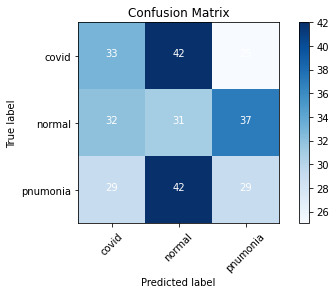

In [45]:
cm_plot_labels=['covid','normal','pnumonia']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')